# The imports

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
import warnings
warnings.filterwarnings("ignore")

# Database connection details
database = 'testspace'
user = 'postgres'
password = '123'
host = 'localhost'
port = '5432'

# Create a database connection
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')

# Data Information
## About:
The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices, and customers.

- Media-related data was created using real data from an Apple iTunes library.

- Customer and employee information was created using fictitious names and addresses that can be located on Google maps, and other well formatted data (phone, fax, email, etc.)

- Sales information was auto generated using random data for a four year period.

## Diagrams
<img src= 'https://raw.githubusercontent.com/m-soro/Business-Analytics/main/SQL-for-Data-Analysis/L4-Project-Query-Music-Store/Misc/001.png' width=600/>

In [2]:
# Join all tables into 1 dataframe to get a closer look at given datas
df = pd.read_sql_query('''
SELECT *
FROM public."Employee"
FULL JOIN public."Customer" ON public."Employee"."EmployeeId" = public."Customer"."SupportRepId"
FULL JOIN public."Invoice" ON public."Invoice"."CustomerId" = public."Customer"."CustomerId"
FULL JOIN public."InvoiceLine" ON public."Invoice"."InvoiceId" = public."InvoiceLine"."InvoiceId"
FULL JOIN public."Track" ON public."InvoiceLine"."TrackId" = public."Track"."TrackId"
FULL JOIN public."Genre" ON public."Track"."GenreId" = public."Genre"."GenreId"
FULL JOIN public."MediaType" ON public."Track"."MediaTypeId" = public."MediaType"."MediaTypeId"
FULL JOIN public."Album" ON public."Album"."AlbumId" = public."Track"."AlbumId"
FULL JOIN public."Artist" ON public."Album"."ArtistId" = public."Artist"."ArtistId"
FULL JOIN public."PlaylistTrack" ON public."PlaylistTrack"."TrackId" = public."Track"."TrackId"
FULL JOIN public."Playlist" ON public."Playlist"."PlaylistId" = public."PlaylistTrack"."PlaylistId"
;
''', engine)
df.head()

EmployeeId LastName FirstName                Title  ReportsTo  BirthDate  \
0         NaN     None      None                 None        NaN        NaT   
1         NaN     None      None                 None        NaN        NaT   
2         NaN     None      None                 None        NaN        NaT   
3         3.0  Peacock      Jane  Sales Support Agent        2.0 1973-08-29   
4         3.0  Peacock      Jane  Sales Support Agent        2.0 1973-08-29   

    HireDate        Address     City State  ...                         Name  \
0        NaT           None     None  None  ...  Protected MPEG-4 video file   
1        NaT           None     None  None  ...     Protected AAC audio file   
2        NaT           None     None  None  ...     Protected AAC audio file   
3 2002-04-01  1111 6 Ave SW  Calgary    AB  ...     Protected AAC audio file   
4 2002-04-01  1111 6 Ave SW  Calgary    AB  ...     Protected AAC audio file   

  AlbumId        Title ArtistId ArtistId        Name PlaylistId TrackId  \
0   271.0  Revelations      8.0      8.0  Audioslave        1.0  3402.0   
1   271.0  Revelations      8.0      8.0  Audioslave        1.0  3389.0   
2   271.0  Revelations      8.0      8.0  Audioslave        1.0  3390.0   
3   271.0  Revelations      8.0      8.0  Audioslave        1.0  3391.0   
4   271.0  Revelations      8.0      8.0  Audioslave        1.0  3392.0   

  PlaylistId   Name  
0        1.0  Music  
1        1.0  Music  
2        1.0  Music  
3        1.0  Music  
4        1.0  Music  

[5 rows x 64 columns]

In [3]:
df.shape

(9432, 64)

In [4]:
#Check Non-Null count, data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9432 entries, 0 to 9431
Data columns (total 64 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   EmployeeId         5577 non-null   float64       
 1   LastName           5577 non-null   object        
 2   FirstName          5577 non-null   object        
 3   Title              5577 non-null   object        
 4   ReportsTo          5576 non-null   float64       
 5   BirthDate          5577 non-null   datetime64[ns]
 6   HireDate           5577 non-null   datetime64[ns]
 7   Address            5577 non-null   object        
 8   City               5577 non-null   object        
 9   State              5577 non-null   object        
 10  Country            5577 non-null   object        
 11  PostalCode         5577 non-null   object        
 12  Phone              5577 non-null   object        
 13  Fax                5577 non-null   object        
 14  Email   

# Analyzing sales by country

To analyze the countries with the highest sales, we need to consider the following metrics for each country:

- Total number of customers: This refers to the overall count of customers from each country.

- Total sales: It represents the sum of sales generated from each country.

- Average value of sales per customer: This metric calculates the average sales amount per customer in each country.

- Average order value: It indicates the average value of each order placed by customers from each country.

Additionally, it's worth noting that there are several countries with only one customer each. To simplify the analysis, we can group these countries together as "Other."

By considering these factors, we can gain a comprehensive understanding of the sales performance in different countries.

In [5]:
t1 = pd.read_sql_query('''
WITH
    country_with_one_customer AS
        (SELECT
            i."BillingCountry" AS country,
            COUNT(DISTINCT i."CustomerId")
        FROM public."Invoice" AS i
        GROUP BY country
        HAVING COUNT(DISTINCT i."CustomerId") = 1),
    country_or_other AS
        (SELECT
            (CASE
                WHEN i."BillingCountry" IN (SELECT country FROM country_with_one_customer) THEN 'Others'::varchar
                ELSE i."BillingCountry"
            END) AS country,
            (CASE
                WHEN i."BillingCountry" IN (SELECT country FROM country_with_one_customer) THEN 1
                ELSE 0
            END) AS sort,
            i.*
        FROM public."Invoice" AS i)
SELECT
    DISTINCT country,
    COUNT(DISTINCT a."CustomerId") AS total_customers,
    SUM(a."Total") AS total_sales, 
    SUM(a."Total")/COUNT(DISTINCT a."CustomerId") AS avg_sale_per_customer,
    SUM(a."Total")/COUNT(DISTINCT a."InvoiceId") AS avg_order_value,
    a.sort
FROM country_or_other AS a
GROUP BY country, a.sort
ORDER BY sort ASC , total_sales DESC
''',engine)
t1

country  total_customers  total_sales  avg_sale_per_customer  \
0             USA               13       523.06              40.235385   
1          Canada                8       303.96              37.995000   
2          France                5       195.10              39.020000   
3          Brazil                5       190.10              38.020000   
4         Germany                4       156.48              39.120000   
5  United Kingdom                3       112.86              37.620000   
6  Czech Republic                2        90.24              45.120000   
7        Portugal                2        77.24              38.620000   
8           India                2        75.26              37.630000   
9          Others               15       604.30              40.286667   

   avg_order_value  sort  
0         5.747912     0  
1         5.427857     0  
2         5.574286     0  
3         5.431429     0  
4         5.588571     0  
5         5.374286     0  
6         6.445714     0  
7         5.517143     0  
8         5.789231     0  
9         5.755238     1

Text(0.5, 1.0, 'Average Order Value by Country')

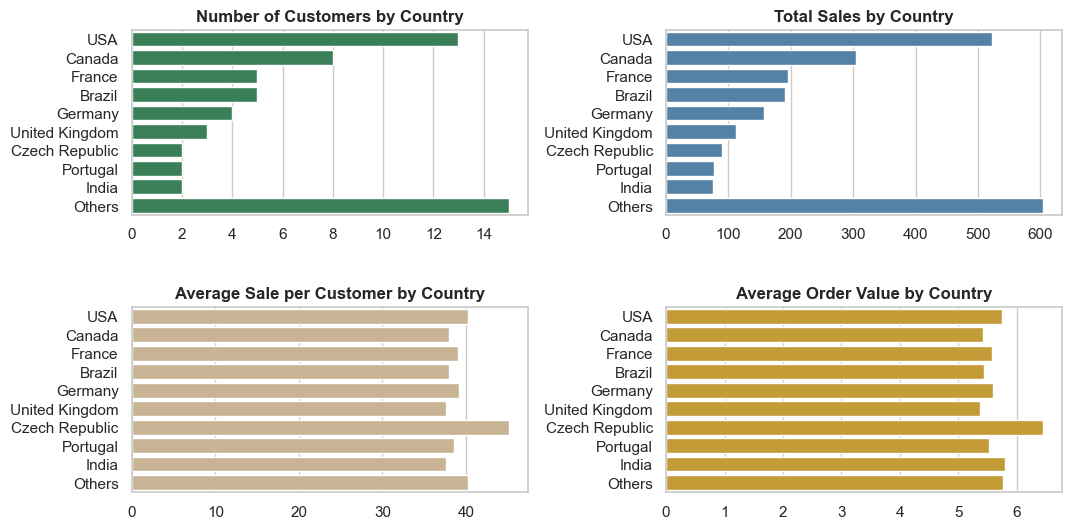

In [6]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
sns.barplot(t1,y='country', x='total_customers', color="seagreen")
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Customers by Country',
         fontdict= {'fontweight':'bold'})

plt.subplot(2,2,2)
sns.barplot(t1,y='country', x='total_sales', color="steelblue")
plt.subplots_adjust(wspace=0.35)
plt.xlabel('')
plt.ylabel('')
plt.title('Total Sales by Country',
         fontdict= {'fontweight':'bold'})

plt.subplot(2,2,3)
sns.barplot(t1,y='country', x='avg_sale_per_customer', color="tan")
plt.subplots_adjust(hspace=0.5, wspace=0.35)
plt.xlabel('')
plt.ylabel('')
plt.title('Average Sale per Customer by Country',
         fontdict= {'fontweight':'bold'})

plt.subplot(2,2,4)
sns.barplot(t1,y='country', x='avg_order_value', color="goldenrod")
plt.subplots_adjust(hspace=0.5, wspace=0.35)
plt.xlabel('')
plt.ylabel('')
plt.title('Average Order Value by Country',
         fontdict= {'fontweight':'bold'})

Upon examining the data, it appears that the average sale per customer and average order value are relatively similar across countries. In light of this, it would be beneficial for the company to concentrate its efforts on countries with a substantial customer base, specifically the USA and Canada. The category labeled as "Others" consists of countries with only one customer each, making it less significant in terms of providing meaningful insights.

In [7]:
avg_order_value_mean = t1[['avg_order_value']].mean()
pct_dif_from_mean = t1[['country']]
pct_dif_from_mean[['%_difference_from_mean']] = ((t1[['avg_order_value']]-avg_order_value_mean)/avg_order_value_mean)*100
pct_dif_from_mean = pct_dif_from_mean.sort_values('%_difference_from_mean', ascending=False)
pct_dif_from_mean = pct_dif_from_mean.reset_index(drop=True)

In [8]:
pct_dif_from_mean

country  %_difference_from_mean
0  Czech Republic               13.778017
1           India                2.189946
2          Others                1.589917
3             USA                1.460600
4         Germany               -1.352039
5          France               -1.604206
6        Portugal               -2.612877
7          Brazil               -4.125882
8          Canada               -4.188924
9  United Kingdom               -5.134552

Text(0, 0.5, '')

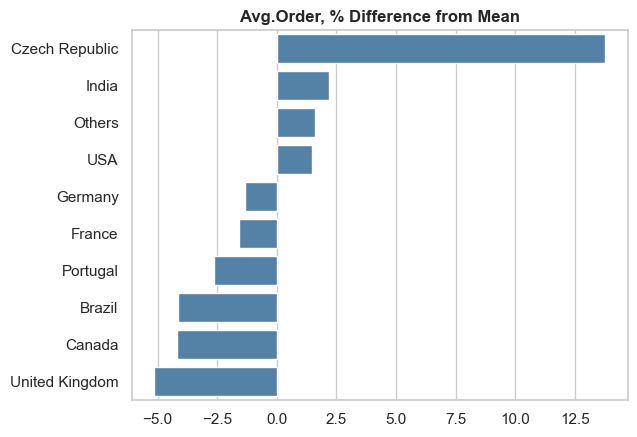

In [9]:
sns.barplot(pct_dif_from_mean, y='country', x='%_difference_from_mean', color='steelblue')
plt.title('Avg.Order, % Difference from Mean',
          fontdict= {'fontweight':'bold'})

plt.xlabel('')
plt.ylabel('')

To summarize, the analysis of sales across different countries reveals that a significant portion of sales takes place in **North America**, specifically **the USA and Canada**, which together make up **approximately 34% of all customers and sales**. On the other hand, countries like the **Czech Republic, the United Kingdom, and Brazil** have relatively fewer customers, but **their average orders are among the highest compared to other countries**. This suggests a potential business opportunity for Chinook store in these three countries. However, it's important to note that the current analysis is based on a limited data sample. To validate the observed trend in this project, the store should consider collecting and analyzing customer data from small marketing campaigns conducted in these three countries.

# Identifying Popular Music Genres

Having understood the countries in which Chinook store sells most, let’s identify the popular music genres among customers in the top five countries which account for most customers and sales: **USA, Canada, Brazil, France, and Germany.**

In [10]:
t2 = pd.read_sql_query('''
WITH 
    popular_genre AS
    (
        SELECT
            g."Name" AS genre,
            COUNT(*) AS tracks_sold
        FROM public."Genre" AS g 
        INNER JOIN public."Track" AS t ON g."GenreId" = t."GenreId"
        INNER JOIN public."InvoiceLine" AS il ON il."TrackId" = t."TrackId"
        INNER JOIN public."Invoice" AS i ON i."InvoiceId" = il."InvoiceId"
        WHERE i."BillingCountry" IN ('USA', 'Canada', 'Brazil', 'France', 'Germany')
        GROUP BY 1)
SELECT
    genre,
    tracks_sold,
    CAST (tracks_sold AS FLOAT)/(SELECT SUM(tracks_sold) FROM popular_genre)*100 AS tracks_sold_pct
FROM popular_genre
ORDER BY 2 DESC
LIMIT 10;
''',engine)
t2

genre  tracks_sold  tracks_sold_pct
0                Rock          472        35.488722
1               Latin          248        18.646617
2               Metal          164        12.330827
3  Alternative & Punk          137        10.300752
4                Jazz           48         3.609023
5               Blues           41         3.082707
6           Classical           29         2.180451
7            R&B/Soul           20         1.503759
8              Reggae           20         1.503759
9            TV Shows           19         1.428571

Text(0, 0.5, '')

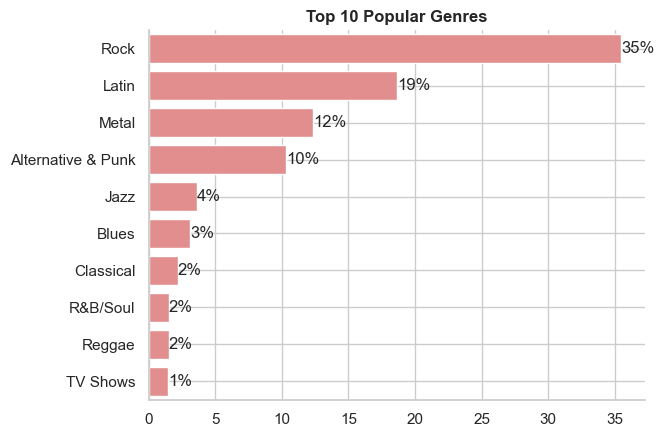

In [11]:
sns.barplot(t2, y='genre', x='tracks_sold_pct', color='lightcoral')
plt.title('Top 10 Popular Genres',
          fontdict= {'fontweight':'bold'})

#Dennotation
for index, row in t2.iterrows():
    plt.text(row['tracks_sold_pct'], index, str(round(row['tracks_sold_pct']))+'%', va='center')

plt.grid(True)
sns.despine()
plt.xlabel('')
plt.ylabel('')

Based on the analyses conducted, it is evident that the **Rock genre** is the most favored among customers, **constituting over half (54%) of all track purchases**. Additionally, genres like **Metal and Alternative & Punk** are also popular, collectively **accounting for 23% of track sales**. Therefore, if the Chinook store intends to market tracks that have a high likelihood of selling well, it would be wise to prioritize these three genres: Rock, Metal, and Alternative & Punk. By focusing on these popular genres, the store can better cater to customer preferences and maximize their sales potential.

In [12]:
spending_on_genre = pd.read_sql_query('''
SELECT g."Name" AS genre, SUM((il."UnitPrice"*il."Quantity")) AS total
FROM public."Customer" AS c
INNER JOIN public."Invoice" AS i USING("CustomerId")
INNER JOIN public."InvoiceLine" AS il USING("InvoiceId")
INNER JOIN public."Track" AS t USING("TrackId")
INNER JOIN public."Genre" AS g USING("GenreId")
GROUP BY genre
ORDER BY total DESC
LIMIT 10;
''',engine)

Text(0.5, 1.0, 'Spending on Genre')

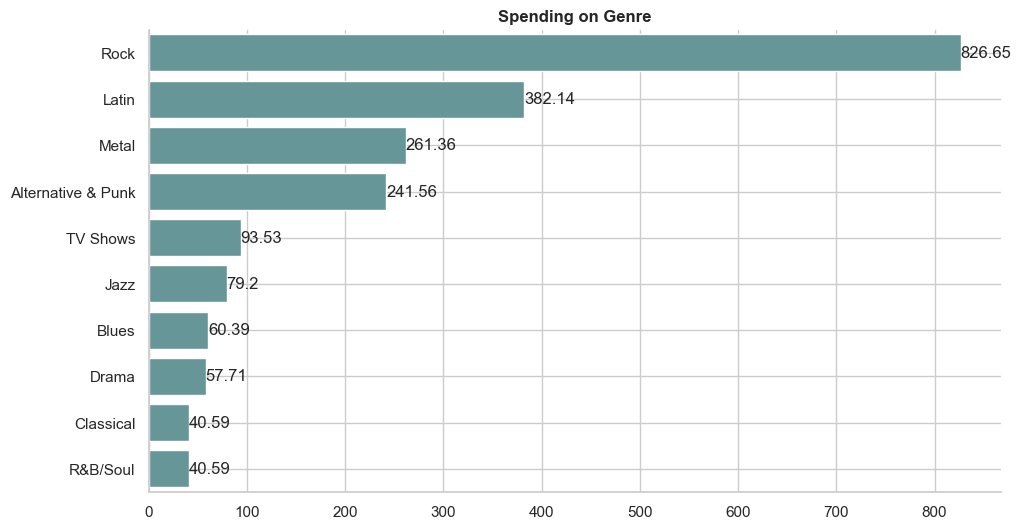

In [13]:
#Data visualization
plt.figure(figsize=(11, 6))
sns.barplot(data=spending_on_genre, x='total', y='genre', color = 'cadetblue')
plt.grid(True)

#Denote the data above each column in the chart
for index, row in spending_on_genre.iterrows():
    plt.text(row['total'], index, str(row['total']), va='center')
    
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.title('Spending on Genre',
          fontdict= {'fontweight':'bold'})

- Based on the above data visualization of this dataset, it is evident that customers spend the most on **Rock music**. The total amount of money spent on Rock music is nearly twice as much as the second-ranking genre, Latin.

- Clearly distinguishing between music genres helps us understand that one genre can attract a large number of listeners, while another genre with a similar name may not enjoy the same level of popularity. For example, in this dataset, although there is significant interest in **Rock music**, **Rock And Roll music** appears to have a more selective audience compared to **Rock**. This is same for **Metal** and **Heavy Metal**.

# Analyzing Album vs Tracks Sales

The previous examinations have uncovered several countries that offer potential investment opportunities for the Chinook media store. Furthermore, these analyses assist in identifying the music genres that are most popular. In order to assist the store in making informed marketing and investment choices in the future, it is crucial to comprehend whether customers typically purchase entire albums or a selection of individual tracks. These are the two available purchasing options at the Chinook store, and customers are unable to add individual tracks to an album purchase.

Consequently, the objective of this section is to determine the proportion of purchases that include individual tracks as opposed to complete albums. To address this inquiry, the following steps were undertaken:

- get an invoice and all purchased tracks or albums associated with the invoice.

- use the `ID` of a purchased album to get all the tracks in the album.

- use the `EXCEPT` operator to check whether an invoice included the purcase of a whole album or individual tracks.

- finally, count invoices that were purchases of whole albums vs individual tracks.

In [14]:
t3 = pd.read_sql_query('''
WITH purchased_tracks AS (
    SELECT
        il."InvoiceId" AS invoice_id,
        t."TrackId" AS track_id,
        t."AlbumId" AS album_id
    FROM public."Track" AS t
    INNER JOIN public."InvoiceLine" AS il ON t."TrackId" = il."TrackId"
),
album_and_tracks AS (
    SELECT
        t."AlbumId" AS album_id,
        t."TrackId" AS track_id
    FROM public."Track" AS t
    INNER JOIN (
        SELECT DISTINCT album_id
        FROM purchased_tracks
    ) AS ta ON t."AlbumId" = ta.album_id
),
album_or_track_sales AS (
    SELECT
        DISTINCT p.invoice_id,
        CASE
            WHEN (
                SELECT COUNT(DISTINCT track_id)
                FROM purchased_tracks
                WHERE invoice_id = p.invoice_id
                EXCEPT
                SELECT COUNT(DISTINCT track_id)
                FROM album_and_tracks
                WHERE album_id = p.album_id
            ) IS NULL AND (
                SELECT COUNT(DISTINCT track_id)
                FROM album_and_tracks
                WHERE album_id = p.album_id
                EXCEPT
                SELECT COUNT(DISTINCT track_id)
                FROM purchased_tracks
                WHERE invoice_id = p.invoice_id
            ) IS NULL THEN 'Yes'
            ELSE 'No'
        END AS album_purchase
    FROM purchased_tracks AS p
)
SELECT
    album_purchase,
    COUNT(invoice_id) AS num_of_invoice,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM album_or_track_sales) *100 AS percent
FROM album_or_track_sales
GROUP BY 1;
''',engine)
t3

album_purchase  num_of_invoice    percent
0             No             410  87.606838
1            Yes              58  12.393162

([<matplotlib.patches.Wedge at 0x2798c51b7f0>,
 [Text(-0.974001664216979, -0.5111954206588274, 'No'),
  Text(1.0625473092143496, 0.5576676570156686, 'Yes')],
 [Text(-0.531273635027443, -0.2788338658139058, '87.6%'),
  Text(0.6198192637083706, 0.32530613325914, '12.4%')])

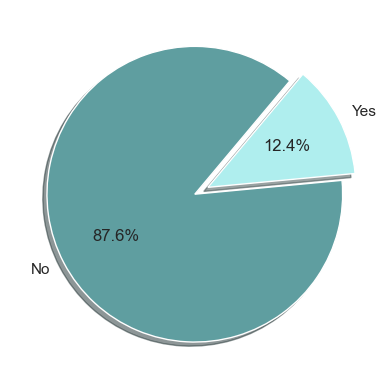

In [15]:
labels = list(t3.album_purchase.values)
sizes = list(t3.percent.values)

plt.pie(sizes,
        explode = (0, 0.1),
        labels = labels,
        colors = ['cadetblue','paleturquoise'],
        shadow = True,
        startangle=50,
        autopct='%1.1f%%')

According to the findings, approximately `88% (87.6%)` of all purchases consist of individual tracks, suggesting that customers have a preference for buying collections of tracks rather than entire albums. Therefore, the Chinook store may consider adjusting its strategy to emphasize the promotion of popular individual tracks in the future.

# Analyzing Employee Sales Performance

It is important for Chinook store to understand the performance of its sales representatives regarding sales of albums/tracks. Therefore, as the final task in this project, we want to understand the total sales (in dollars) made by each sales representative.

In [16]:
pd.read_sql_query('''
WITH
    employee_sales AS
    (
     SELECT
         c."SupportRepId" AS support_rep_id,
         COUNT(*) AS num_of_sales,
         SUM(i."Total") AS total_sales_value
     FROM public."Customer" AS c
     INNER JOIN public."Invoice" AS i ON c."CustomerId"=i."CustomerId"
     GROUP BY 1
    )
    
SELECT
    e."FirstName" || ' ' || e."LastName" AS name,
    e."HireDate",
    es.num_of_sales,
    es.total_sales_value
FROM public."Employee" AS e
INNER JOIN employee_sales AS es ON e."EmployeeId" = es.support_rep_id
ORDER BY es.total_sales_value DESC;
''',engine)

name   HireDate  num_of_sales  total_sales_value
0   Jane Peacock 2002-04-01           146             833.04
1  Margaret Park 2003-05-03           140             775.40
2  Steve Johnson 2003-10-17           126             720.16

Jane Peacock, the employee with the longest tenure at Chinook store, achieves the highest sales revenue. Magaret Park, who joined the store one year later than Jane, has recorded six fewer sales than her. These findings indicate that sales performance might be influenced by the duration of employment. Consequently, it is advisable for the store to prioritize the well-being of long-serving employees.